In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)

# Normalized Chebyshev Low-Pass $g_{k}$ Values

<!--![Drag Racing](Rx-Antialias1.png)-->
<!--![N_Odd](Fig1.svg)-->

With $\omega_{c} = 1$, the normalized Chebyshev $N$ section doubly terminated low-pass filter element values are given by the following:

$R_{S} = g_{0} = 1$

$R_{S}$ is the source resistor.



$g_{N+1} = \Bigg\{ \begin{array}{ll}1&\text{$N$ odd}\\2k^2 + 1 - 2k\sqrt{1+k^2}&\text{$N$ even}\end{array}$



$R_{L} = \Bigg\{ \begin{array}{ll}
    g_{N+1} & g_{N}=\text{inductor (series element)}
    \\\displaystyle
    \frac{1}{g_{N+1}} & g_{N}=\text{capacitor (shunt element)}
    \end{array}$

$R_{L}$ is the load resistor.



${\beta} = ln\displaystyle\frac{\sqrt{1+k^2}+1}{\sqrt{1+k^2}-1}$



So far, variable $k$ is such that $10\log_{10} (k^2+1) = \text{passband ripple in dB}$.  

For the equations below, $k$ is the element index.  
This sometimes confusing notation is used in **_Foundations for Microwave Engineering, 2nd Edition, page 597_**.  On the same page, it is believed that the statement between equations **_(8.101b)_** and **_(8.101c)_** is reversed.  See **_FIGURE 8.21_** on **_page 595_** and equation **_(8.98)_** on **_page 596_** for clarification. 



$g_{1}=\displaystyle\frac{2a_{1}}{sinh\bigg(\displaystyle\frac{\beta}{2N}\bigg)}$



$g_{k}=\displaystyle\frac{4a_{k-1}a_{k}}{b_{k-1}g_{k-1}}\;\;\;\;\;\;k=2,3,...,N$



$a_{k}=sin\bigg(\displaystyle\frac{2k-1}{2N}\pi\bigg)\;\;\;\;\;\;k=1,2,...,N$



$b_{k}=sinh^2\bigg(\displaystyle\frac{\beta}{2N}\bigg)+sin^2\bigg(\displaystyle\frac{k\pi}{N}\bigg)\;\;\;\;\;\;k=1,2,...,N-1$



**Figure 1** and **Figure 2** below show the different configurations of a low-pass filter.

![N_Odd](svg_files/Fig1.svg)

| Figure 1 |
| :-----------: |
| Odd $N$ Sections Low-Pass.  Series First and Shunt First Configuration | 

$~$
![N_Even](svg_files/Fig2.svg)

| Figure 2 |
| :-----------: |
| Even $N$ Sections Low-Pass.  Series First and Shunt First Configuration | 

### Function for Generating $g_{k}$ Values

In [2]:
def g_values(N, Rip_dB, First_Element = 'shnt'):
    """
    Function for calculating gk values
    
    N = Number of sections.  An integer
    Rip_dB = Chebyshev passband ripple in dB
    First_Element = 'shnt'(shunt) or 'srs'(series)
        if N is even, normalized RL is not 1 and depends on the 
        orientation of the 1st element.
    """
    
    k2 = 10**(Rip_dB/10)-1
    beta = np.log((np.sqrt(1+k2)+1)/(np.sqrt(1+k2)-1))

    k = np.arange(0, N+1)
    a = np.sin((2*k-1)/(2*N)*np.pi)
    b = np.sinh(beta/(2*N))**2 + np.sin(k*np.pi/N)**2

    g = np.array([1, 2*a[1]/np.sinh(beta/(2*N))])

    for k in k[2:]:
        g = np.append(g, 4*a[k-1]*a[k]/(b[k-1]*g[k-1]))

    if N%2 == 0:
        if First_Element == 'shnt':
            g = np.append(g, 2*k2+1-2*np.sqrt(k2)*np.sqrt(1+k2))
        else:
            g = np.append(g, 1/(2*k2+1-2*np.sqrt(k2)*np.sqrt(1+k2)))
            
    else:
         g = np.append(g, 1)
            
    return g

### Calculate and List the $g_{k}$ Values for an $N$ Section Low-Pass
The $g_{k}$ values of the normalized low-pass network should be computed for both an odd and even $N$ in order to observe the differences in the passband ripple behavior (**note the DC response**) and source/load terminations.

In [3]:
N = 5
Ripple = 0.025 #dB
#First_Element = 'shnt'
First_Element = 'srs'

g = g_values(N, Ripple, First_Element)

#Print g values
print("k\t", "gk")
print("--\t", "-------")
for k in range(len(g)):
    print(k,"\t", "{0:.5f}".format(g[k]))

k	 gk
--	 -------
0 	 1.00000
1 	 0.88029
2 	 1.35494
3 	 1.70911
4 	 1.35494
5 	 0.88029
6 	 1.00000


___

# Applying the $ABCD$ Matrix for Network Analysis
<!--![QUCS Simulation](sim.png)-->
The $ABCD$ matrix or $\left[\begin{array}{ccc}A & B \\ C &D\end{array}\right]$ of the entire network is computed by the dot product of the $ABCD$ matrices of the individual shunt, series, and transformer elements.  The transformer element is needed to transform $R_{L}$ to $R_{S}$ when $N$ is even.  It is not needed when N is odd.  For this reason, most physical realizations of low-pass and high-pass Chebyshev filters are with an odd number of elements. These elements and their corresponding $ABCD$ matrices are listed below:

$$Shunt\to \left[\begin{array}{ccc}1 & 0 \\ Y & 1\end{array}\right]\text{, where }Y=j\omega g_{k}$$

$$Series\to \left[\begin{array}{ccc}1 & Z \\ 0 & 1\end{array}\right]\text{, where }Z=j\omega g_{k}$$

$$Transformer\to \left[\begin{array}{ccc}N & 0 \\ 0 & N^{-1}\end{array}\right]\text{, where }N=\sqrt{\frac{R_{L}}{R_{S}}}$$

The $A$, $B$, $C$, and $D$ parameters of the composite matrix are used to compute the $S$-$Parameters$ of the network.  The conversion equations are the following:

$$S_{11}=\frac{A+BR_{S}^{-1}-CR_{S}-D}{A+BR_{S}^{-1}+CR_{S}+D}$$

$$S_{21}=\frac{2}{A+BR_{S}^{-1}+CR_{S}+D}$$

$$S_{12}=\frac{2(AD-BC)}{A+BR_{S}^{-1}+CR_{S}+D}$$

$$S_{22}=\frac{-A+BR_{S}^{-1}-CR_{S}+D}{A+BR_{S}^{-1}+CR_{S}+D}$$

See **_Microwave Engineering, 3rd Edition, pages 183-189_** for additional information on $ABCD$ matrices. 

### Function for Computing the $S$-$Parameters$ of an All Pole Doubly Terminated Ladder Network

In [4]:
def SAPLad(E, First_Element = 'shnt'):
    
    """
    S-parameter All Pole Ladder(SAPLad)
    Function for computing the S-Parameters of an all pole
    doubly terminated ladder network
    
    E = an array of network elements including the terminations
    First_Element = 'shnt'(shunt) or 'srs'(series)
    """
    
    w = sp.symbols('w')
    Rs = E[0][0]
    Rl = E[0][1]
    orientation = First_Element
    abcd = np.matrix([[1, 0], [0, 1]])
        
    for k in range(1, len(E)):
        if orientation == 'shnt':
            abcd = np.dot(abcd, np.matrix([[1, 0], [(1j*w*E[k][0]), 1]]))
            abcd = np.dot(abcd, np.matrix([[1, 0], [(1j*w*E[k][1])**-1, 1]]))
            orientation = 'srs'
        else:
            abcd = np.dot(abcd, np.matrix([[1, (1j*w*E[k][0])], [0, 1]]))
            abcd = np.dot(abcd, np.matrix([[1, (1j*w*E[k][1])**-1], [0, 1]]))
            orientation = 'shnt'

    abcd = np.dot(abcd, np.matrix([[np.sqrt(Rl/Rs), 0], [0, 1/np.sqrt(Rl/Rs)]]))
    
    A = abcd[0,0]
    B = abcd[0,1]
    C = abcd[1,0]
    D = abcd[1,1]
    
    denom = A+B/Rs+C*Rs+D
    S11_sym = (A+B/Rs-C*Rs-D)/denom
    S21_sym = 2/denom
    S12_sym = 2**(A*D-B*C)/denom
    S22_sym = (-A+B/Rs-C*Rs+D)/denom
    
    S11 = sp.lambdify(w, S11_sym, 'numpy')
    S21 = sp.lambdify(w, S21_sym, 'numpy')
    S12 = sp.lambdify(w, S12_sym, 'numpy')
    S22 = sp.lambdify(w, S22_sym, 'numpy')
    
    return np.array([S11, S21, S12, S22])

___

# Low-Pass Filter Element Values From $g_{k}$ Values ($g_{k}$ Value Validation)

For a cutoff frequency of $\omega_{c}$ and a termination of $Z_{o}$, the $g_{k}$ values need to be properly scaled.

If $N$ is odd, the terminations are both $Z_{o}$.  In general, they are the following:

$Z_{o}g_{0}$  

$Z_{o}g_{N+1}$

The series inductors and shunt capacitors are scaled as below:

$L_{k}=g_{k}\dfrac{Z_{o}}{\omega_{o}}\;\;\;k\neq{0},\;\text{if first element is series, k is odd.  Else, k is even}$ 

$C_{k}=\dfrac{g_{k}}{Z_{o}\omega_{o}}\;\;\;k\neq{0},\;\text{if first element is series, k is even.  Else, k is odd}$

### Function for Scaling the Frequency and Impedance of a Normalized Low-Pass Filter

In [5]:
def Low(g, Zo = 50, wc = 1, First_Element = 'shnt'):
    
    """
    Lowpass Scaling
    Scale gk values to terminating resistance Zo and cutoff frequency wc.
    Place the scaled values in an array of array. 
    
    g = gk values computed with function 'g_values'
    Zo = Source resistance Rs, and Rl if N is odd
    wc = The lowpass equi-ripple cutoff frequency in radians
    First_Element = 'shnt'(shunt) or 'srs'(series)
    """
    N = len(g)-2
    orientation = First_Element
    lp = np.array([[g[0]*Zo,g[N+1]*Zo]])
    for i in range(1, N+1):
        if orientation=='srs':
            #series inductor and capacitor(set to infinity)
            lp = np.append(lp,[[g[i]/wc*Zo, np.inf]],axis=0)
            orientation = 'shnt'
        else:
            #shunt capacitor and inductor(set to infinity)
            lp = np.append(lp,[[g[i]/wc/Zo, np.inf]],axis=0)
            orientation = 'srs'
    return lp

### Compute and Plot $S$-$Parameters$ of a Low-Pass Filter

Component Values
L(k):	  [  8.803e-08   1.709e-07   8.803e-08]
C(k):	  [  5.420e-11   5.420e-11]
Zo:	  [ 50.  50.]


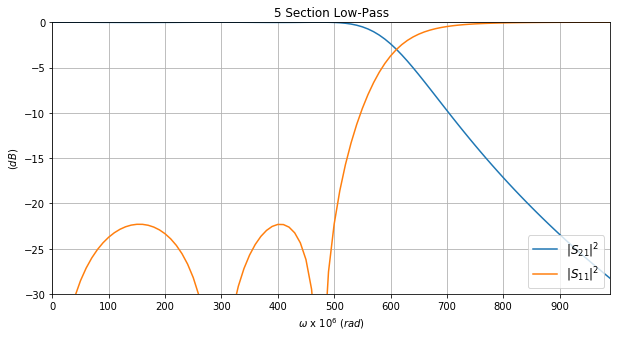

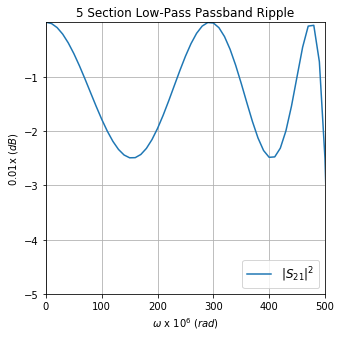

In [6]:
# Previously defined
## N = 4
## Ripple = 0.1 
## First_Element = 'srs'
## g = g_values(N, Ripple, First_Element)
Zo=50
wc=500e6

lp1 = Low(g, Zo, wc, First_Element)
print('Component Values')
print('L(k):\t ',lp1[1::2,0])
print('C(k):\t ',lp1[2::2,0])
print('Zo:\t ',lp1[0])


S_lp1 = SAPLad(lp1, First_Element)
S11=S_lp1[0]
S21=S_lp1[1]

wstep = 10e6
w = np.arange(0, 2*wc, wstep)
S11_dB = 20*np.log10(abs(S11(w))+1e-3) #1e-3 is added to prevent log(0) condition
S21_dB = 20*np.log10(abs(S21(w)))

fscale=1e6
plt.figure(1,(10,5))
plt.plot(w/fscale, S21_dB, label='$|S_{21}|^2$')
plt.plot(w/fscale, S11_dB, label='$|S_{11}|^2$')
plt.axis([w[0]/fscale, w[-1]/fscale, -30, 0])
plt.xticks(np.arange(w[0]/fscale, (w[-1] + wstep)/fscale, 100))
plt.title(str(N)+" Section Low-Pass")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel('($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

yscale=100
plt.figure(2,(5,5))
plt.plot(w/fscale, yscale*S21_dB, label='$|S_{21}|^2$')
plt.axis([w[0]/fscale, wc/fscale, -2*Ripple*yscale, 0])
plt.yticks(np.arange(-2*Ripple*yscale, 0, 2*Ripple*yscale/5))
plt.title(str(N)+" Section Low-Pass Passband Ripple")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel(str(1/yscale)+ 'x ($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

___

# Narrowband Band-Pass Filters Using the $K$ and $Q$ Method

If $N$ is even, use a series element for the first element in the computation for $g_{k}$. This way, $Q_{ext1}=Q_{ext2}$ and the final band-pass filter is symmetric.

$fbw=\dfrac{bw}{f_{o}}$

$K_{i,i+1}=\dfrac{fbw}{\sqrt{g_{i}g_{i+1}}}$

$Q_{ext1}=\dfrac{g_{0}g_{1}}{fbw}$

$Q_{ext2}=\dfrac{g_{N}g_{N+1}}{fbw}$

In the synthesis process, one can choose an $L_{r}$ value to minimize the loss in the passband of real physical filters.  At a given frequency, the $Q$ factor of the inductor will vary with value and construction.  However, with an arbitrary $L_{r}$, the required termination resistance $R_{p}$ of the filter will most likely deviate from $50\Omega$.

$Z_{r}=2\pi f_{o}L_{r}$ 

$R_{p}=Q_{ext}Z_{r}$

In **Figure 3**, the intermediate band-pass filter schematic with the coupling component $K$ yet to be defined is shown.

$~$
![KQ_1](svg_files/Fig3.svg)
$~$

| Figure 3 |
| :-----------: |
| Band-Pass Filter with Undefined $K$ | 

**For tunable band-pass filters, inductors($Lk$) are used as the coupling element because their values remain nearly the same as the filter center frequency $\omega_{o}$ along with its passband bandwidth is shifted.**  This conversion of the $K$ element to inductors is shown in **Figure 4**.  

$Lk_{i,i+1}=\dfrac{L_{r}}{K_{i,i+1}}$

For fixed frequency band-pass filters, coupling using capacitors are desired because of their higher $Q$ factor, compact dimensions, and lower cost.  



$~$
![KQ_2](svg_files/Fig4.svg)
$~$

| Figure 4 |
| :-----------: |
| Using Series Inductors as $K$ Elements | 

After the substitution of the $Lk_{i,i+1}$ for $K$, the negative shunt inductors are absorded by $L_{r}$ resulting in $Lsh_{i}$.  **Figure 5** shows the resulting band-apss filter schematics.

[//]: # ($Lsh_{i}=\Bigg\{ \begin{array}{ll}
    \dfrac{1}{ \frac{1}{L_{r}}  + \frac{-1}{Lk_{i,i+1}} } & i=1,N
    \\
    \dfrac{1}{ \frac{1}{L_{r}} + \frac{-1}{Lk_{i-1,i}} + \frac{-1}{Lk_{i,i+1}} } & i=2,N-1
    \end{array}$)
       
$Lsh_{i}=\Big\{ \begin{array}{ll}
    L_{r}\parallel{Lk_{i,i+1}} & i=1,N
    \\
    L_{r}\parallel{-Lk_{i-1,i}}\parallel{-Lk_{i,i+1}} & i=2,...N-1
    \end{array}$
    

For more information on the $K$ and $Q$ method of band-pass filter design, see **_Handbook of FILTER SYNTHESIS, pages 298-310_**.  More specifically, the example on **_pages 309-310_** but watch out for the errors.

$~$
![KQ_3](svg_files/Fig5.svg)
$~$

| Figure 5 |
| :-----------: |
| Substitution of $K$ Elements | 

### Function for Calculating the Element Values of a Band-Pass Filter Using the $K$ and $Q$ Method

In [7]:
def BP_kq(g, wo, bw, Lr=0, Zo=50):
    """
    K abd Q method for narrowband band-pass filters.
    If Lr=0, then Rp is set to Zo ohms and Lr is computed accordingly.
    wo (rads)
    bw (rads)
    Lr (H)
    Outputs capacitors in Farads and inductors in Henries 
    """
    # Fractional BW
    fbw = bw/wo

    # Terminating resistance Rp   
    Qex = g[0]*g[1]/fbw
    
    if Lr==0:
        Rp = Zo
        Zres = Rp/Qex
        Lr = Zres/wo
    else:
        Lr = Lr
        Zres = wo*Lr
        Rp = Qex*Zres
        
    # From chosen inductor, calculate resonant capacitor
    Cr = 1/(Lr*wo**2)
    
    index = np.arange(N)
    
    # Calculate coupling coeff K
    i=index[1:]
    K = fbw/np.sqrt(g[i]*g[i+1])

    #calculate series coupling inductor
    Lk = Lr/K
    Lk = np.append(Lk,np.inf)

    #calculate shunt inductors
    i=index[:]
    Lsh = 1/(1/Lr-1/Lk[i]-1/Lk[i-1])

    bp=np.array([[Rp,Rp]])
    for i in index:
        bp = np.append(bp,[[Cr,Lsh[i]]],axis=0)
        if i != len(index)-1:
            bp = np.append(bp,[[Lk[i],np.inf]],axis=0)
    return bp

### Compute and Plot $S$-$Parameters$ of a Band-Pass Filter Using the $K$ and $Q$ Method

Component Values
Lsh(i):	  [  1.262e-08   1.310e-08   1.290e-08   1.310e-08   1.262e-08]
Cr(i):	  [  9.259e-12   9.259e-12   9.259e-12   9.259e-12   9.259e-12]
Lk(i):	  [  2.457e-07   3.424e-07   3.424e-07   2.457e-07]
Rp:	  [ 594.193  594.193]


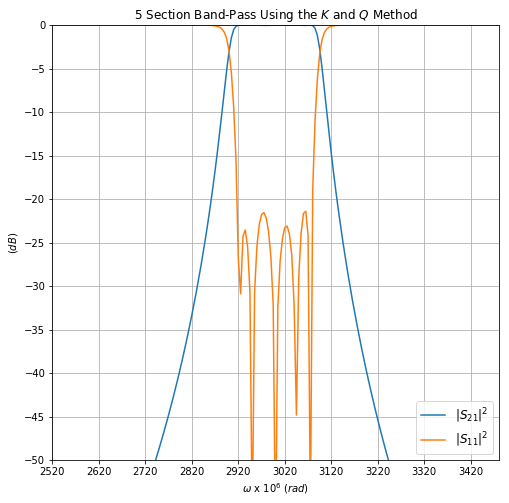

In [8]:
# Previously defined
## N = 4
## Ripple = 0.1 
## First_Element = 'srs'
## g = g_values(N, Ripple, First_Element)
wo = 3000e6
bw = 160e6
Lr = 12e-9 #Choose your inductor(H)
#Lr = 0

bp1 = BP_kq(g, wo, bw, Lr)
print('Component Values')
print('Lsh(i):\t ',bp1[1::2,1])
print('Cr(i):\t ',bp1[1::2,0])
print('Lk(i):\t ',bp1[2::2,0])
print('Rp:\t ',bp1[0])

First_Element = 'shnt'
S_bp1 = SAPLad(bp1, First_Element)
S11 = S_bp1[0]
S21 = S_bp1[1]

wstep = 5e6
w = np.arange(wo-3*bw, wo+3*bw, wstep)
S11_dB = 20*np.log10(abs(S11(w))+1e-3) #1e-3 is added to prevent log(0) condition
S21_dB = 20*np.log10(abs(S21(w)))

fscale=1e6
plt.figure(1,(8,8))
plt.plot(w/fscale, S21_dB, label='$|S_{21}|^2$')
plt.plot(w/fscale, S11_dB, label='$|S_{11}|^2$')
plt.axis([w[0]/fscale, (w[-1]+wstep)/fscale, -50, 0])
plt.xticks(np.arange(w[0]/fscale, (w[-1] + wstep)/fscale, 100))
plt.yticks(np.arange(-50, 5, 5))
plt.title(str(N)+" Section Band-Pass Using the $K$ and $Q$ Method")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel('($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

### Transformation of $R_{p}$ to a Desired $Z_{o}$

One method to transform $R_{p}$ to a desired $Z_{o}$ is to first split $Lsh_{1}$ into inductors $L_{p}$ and $Lshp$. This is  shown in **Figure 6**.



$~$
![KQT_1](svg_files/Fig6.svg)
$~$

| Figure 6 |
| :-----------: |
| Split $Lsh_{1}$ into $L_{p}$ and $Lshp$ | 

The choice of $L_{p}$ is such that the parallel combination of or $R_{p}$ and $L_{p}$ is equivalent to the series combination of $Z_{o}$ and $L_{l}$ at $\omega_{o}$.  This is illustrated in **Figure 7**.

$~$
![KQT_2](svg_files/Fig7.svg)
$~$

| Figure 7 |
| :-----------: |
| $R_{p}\parallel{L_{p}}$ to $Z_{o}+L_{l}$  | 

Equate the $real$ and $imaginary$ parts of $R_{p}\parallel{L_{p}}$ with $Z_{o}+L_{l}$.  This results in the following equations:

$L_{p}=\dfrac{R_{p}}{\omega_{o}}\sqrt{\dfrac{Z_{o}}{R_{p}-Z_{o}}}$

$L_{l}=\dfrac{R_{p}^{2}L_{p}}{R_{p}^{2}+(\omega_{o}L_{p})^{2}}$

The 1st and last shunt inductor then becomes $Lshp$ (for a symmetric band-pass design).

$Lshp=Lsh_{1}\parallel{-L_{p}}$

**Figure 8** shows the final transformed band-pass filter.

$~$
![KQT_3](svg_files/Fig8.svg)
$~$

| Figure 8 |
| :-----------: |
| Transformed Band-Pass Filter  | 

### Function to Transform to $Z_{o}$ with a Series Inductor $L_{l}$

In [9]:
def transform(E, wo, Zo=50):
    Ec=np.copy(E)
    Rp=Ec[0,0]
    Lsh1=Ec[1,1]
    Lp=Rp/wo*np.sqrt(Zo/(Rp-Zo))
    Ll=(Rp**2)*Lp/(Rp**2+(wo*Lp)**2)
    Lshp=1/(1/Lsh1-1/Lp)
    Ec[1,1]=Lshp
    Ec[-1,1]=Lshp
    bp_t=np.array([[Zo,Zo]])
    bp_t = np.append(bp_t,[[Ll,np.inf]],axis=0)
    bp_t = np.append(bp_t,Ec[1:],axis=0)
    bp_t = np.append(bp_t,[[Ll,np.inf]],axis=0)
    return bp_t

### Apply Transformer and Plot Resulting Band-Pass Filter

Component Values
Lsh(i):	  [  1.597e-08   1.310e-08   1.290e-08   1.310e-08   1.597e-08]
Cr(i):	  [  9.259e-12   9.259e-12   9.259e-12   9.259e-12   9.259e-12]
Lsr(i):	  [  5.498e-08   2.457e-07   3.424e-07   3.424e-07   2.457e-07   5.498e-08]
Rp:	  [ 50.  50.]


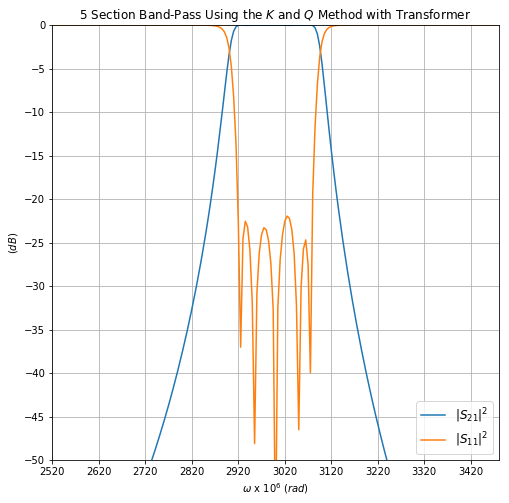

In [10]:
First_Element = 'srs'
bp_t = transform(bp1, wo, Zo)
print('Component Values')
print('Lsh(i):\t ',bp_t[2::2,1])
print('Cr(i):\t ',bp_t[2::2,0])
print('Lsr(i):\t ',bp_t[1::2,0]) #These are no longer just Lk so the generic Lsr (series inductor) is used.
print('Rp:\t ',bp_t[0])

S_bp2 = SAPLad(bp_t, First_Element)
S11 = S_bp2[0]
S21 = S_bp2[1]

wstep = 5e6
w = np.arange(wo-3*bw, wo+3*bw, wstep)
S11_dB = 20*np.log10(abs(S11(w))+1e-3) #1e-3 is added to prevent log(0) condition
S21_dB = 20*np.log10(abs(S21(w)))

fscale=1e6
plt.figure(1,(8,8))
plt.plot(w/fscale, S21_dB, label='$|S_{21}|^2$')
plt.plot(w/fscale, S11_dB, label='$|S_{11}|^2$')
plt.axis([w[0]/fscale, (w[-1]+wstep)/fscale, -50, 0])
plt.xticks(np.arange(w[0]/fscale, (w[-1] + wstep)/fscale, 100))
plt.yticks(np.arange(-50, 5, 5))
plt.title(str(N)+" Section Band-Pass Using the $K$ and $Q$ Method with Transformer")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel('($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

___

# Tunable Band-Pass Filters 

In most tunable band-pass filters, the capacitors are varied to shift the filter's passband.  Components that produce variable capacitances are diode varactors, switch capacitor banks, and Barium Strontium Titanate (BST) varactors.  Using the previously synthesized band-pass filter, the passband responds with various shunt $C_{r}$ values are evaluated.    

### Compute the $S$-$Parameters$ of Band-Pass Filter with Various $C_{r}$ Values

In [11]:
bp_t_copy=np.copy(bp_t)
Cr=bp_t_copy[2,0]
tuned_bp=[] #list for storing the the S-Parameters of band-pass filter tuned to various frequencies
wstep = 5e6
w = np.arange(wo-900e6, wo+1500e6, wstep)
DCr=[-3.25, -1.75, 0, 2.5, 6] #capacitance delta from previously synthesized band-pass filter
for delta_C in DCr:   
    bp_t_copy[2::2,0] = Cr + delta_C*1e-12    
    print('Processing: Cr = '+str(Cr + delta_C*1e-12))    
    S_bp2 = SAPLad(bp_t_copy, First_Element)
    S11 = S_bp2[0]
    S21 = S_bp2[1]        
    S11_dB = 20*np.log10(abs(S11(w))+1e-3) #1e-3 is added to prevent log(0) condition
    S21_dB = 20*np.log10(abs(S21(w)))    
    tuned_bp .append((S21_dB,S11_dB))
print('Finished')

Processing: Cr = 6.00925925926e-12
Processing: Cr = 7.50925925926e-12
Processing: Cr = 9.25925925926e-12
Processing: Cr = 1.17592592593e-11
Processing: Cr = 1.52592592593e-11
Finished


### Plot Band-Pass Filter Responses with Varied $C_{r}$

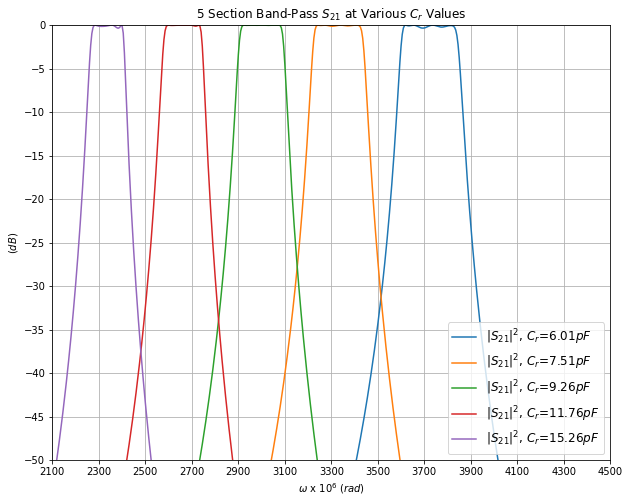

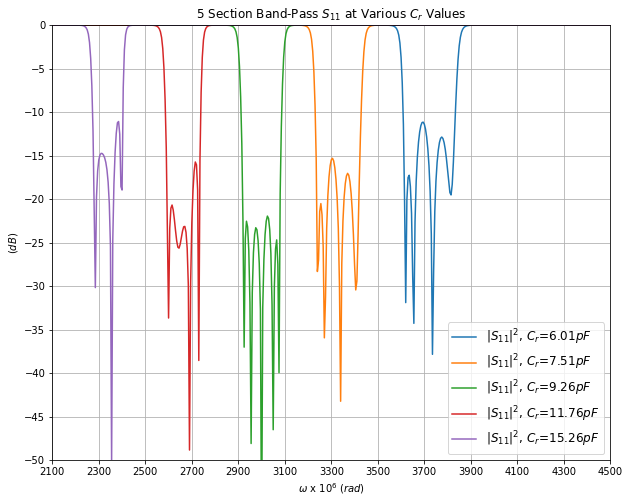

In [12]:
fscale=1e6
plt.figure(1,(10,8))
for i in range(len(tuned_bp)):
    Cr_str='{0:0.2f}'.format(Cr*1e12+DCr[i])
    plt.plot(w/fscale, tuned_bp[i][0], label='$|S_{21}|^2$, $C_{r}$='+Cr_str+'$pF$')    
plt.axis([w[0]/fscale, (w[-1]+wstep)/fscale, -50, 0])
plt.xticks(np.arange(w[0]/fscale, (w[-1] + 200e6)/fscale, 200))
plt.yticks(np.arange(-50, 5, 5))
plt.title(str(N)+" Section Band-Pass $S_{21}$ at Various $C_{r}$ Values")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel('($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

plt.figure(2,(10,8))
for i in range(len(tuned_bp)):
    Cr_str='{0:0.2f}'.format(Cr*1e12+DCr[i])
    plt.plot(w/fscale, tuned_bp[i][1], label='$|S_{11}|^2$, $C_{r}$='+Cr_str+'$pF$')
plt.axis([w[0]/fscale, (w[-1]+wstep)/fscale, -50, 0])
plt.xticks(np.arange(w[0]/fscale, (w[-1] + 200e6)/fscale, 200))
plt.yticks(np.arange(-50, 5, 5))
plt.title(str(N)+" Section Band-Pass $S_{11}$ at Various $C_{r}$ Values")
plt.xlabel('$\omega$ x $10^{6}$ ($rad$)')
plt.ylabel('($dB$)')
plt.legend(loc='lower right', shadow=False, fontsize='large')
plt.grid()
plt.show()

### Observations of the Outcomes

As $C_{r}$ is varied and the intended $\omega_{o}$ of the synthesized band-pass is shifted, the $S_{11}$ response degrades along with the passband ripple.  Also, the bandwith expands and contracts with higher and lower $\omega_{o}$ respectively.  This tunable filter is still usefull within some frequency tuning range where the deviation in its response is still tolerable.       

---